In [1]:
# libraries 
import numpy as np
#import cvxpy
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import time
import scipy
from scipy.sparse.linalg import LinearOperator
import torch
import sklearn.linear_model
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


In [2]:
class FCNetwork(nn.Module):
    def __init__(self, H, num_classes=10, input_dim=3072):
        self.num_classes = num_classes
        super(FCNetwork, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(input_dim, H, bias=False), nn.ReLU())
        self.layer2 = nn.Linear(H, num_classes, bias=False)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        out = self.layer2(self.layer1(x))
        return out
    
# functions for generating sign patterns
def check_if_already_exists(element_list, element):
    # check if element exists in element_list
    # where element is a numpy array
    for i in range(len(element_list)):
        if np.array_equal(element_list[i], element):
            return True
    return False

class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        else:
            self.X = X
            
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        else:
            self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class PrepareData3D(Dataset):
    def __init__(self, X, y, z):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        else:
            self.X = X
            
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        else:
            self.y = y
        
        if not torch.is_tensor(z):
            self.z = torch.from_numpy(z)
        else:
            self.z = z
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.z[idx]


def generate_sign_patterns(A, P, verbose=False):
    # generate sign patterns
    n, d = A.shape
    unique_sign_pattern_list = []  # sign patterns
    u_vector_list = []             # random vectors used to generate the sign paterns

    for i in range(P):
        if verbose and i%100==0:
            print(i)
        # obtain a sign pattern
        u = np.random.normal(0, 1, (d,1)) # sample u
        sampled_sign_pattern = (np.matmul(A, u) >= 0)[:,0]

        #check whether that sign pattern has already been used
        if not check_if_already_exists(unique_sign_pattern_list, sampled_sign_pattern):
            unique_sign_pattern_list.append(sampled_sign_pattern)
            u_vector_list.append(u)

    if verbose:
        print("Number of unique sign patterns generated: " + str(len(unique_sign_pattern_list)))
    return unique_sign_pattern_list, u_vector_list

def generate_sign_patterns_fast(A, P, verbose=False):
    # generate sign patterns
    n, d = A.shape
    unique_sign_pattern_list = []  # sign patterns
    u_vector_list = []             # random vectors used to generate the sign paterns
    umat = np.random.normal(0, 1, (d,P))
    sampled_sign_pattern_mat = (np.matmul(A, umat) >= 0)
    for i in range(P):
        if verbose and i%100==0:
            print(i)
        sampled_sign_pattern = sampled_sign_pattern_mat[:,i]
        #check whether that sign pattern has already been used
        #if not check_if_already_exists(unique_sign_pattern_list, sampled_sign_pattern):
        unique_sign_pattern_list.append(sampled_sign_pattern)
        u_vector_list.append(umat[:,i])
    if verbose:
        print("Number of sign patterns generated: " + str(len(unique_sign_pattern_list)))
    return unique_sign_pattern_list, u_vector_list

def one_hot(labels, num_classes=10):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels.long()] 

In [11]:
def loss_func_primal(yhat, y, model, beta):
    loss = 0.5 * torch.norm(yhat - y)**2
    
    ## l2 norm on first layer weights, l1 squared norm on second layer
    for layer, p in enumerate(model.parameters()):
        if layer == 0:
            loss += beta/2 * torch.norm(p)**2
        else:
            loss += beta/2 * sum([torch.norm(p[:, j], 1)**2 for j in range(p.shape[1])])
    
    return loss

def validation_primal(model, testloader, beta, device):
    test_loss = 0
    test_correct = 0

    for ix, (_x, _y) in enumerate(testloader):
        _x = Variable(_x).float().to(device)
        _y = Variable(_y).float().to(device)

        output = model.forward(_x)
        yhat = model(_x).float()

        loss = loss_func_primal(yhat, one_hot(_y).to(device), model, beta)

        test_loss += loss.item()
        test_correct += torch.eq(torch.argmax(yhat, dim=1), torch.squeeze(_y)).float().sum()

    return test_loss, test_correct

# solves nonconvex problem
def sgd_solver_pytorch_v2(ds, ds_test, num_epochs, num_neurons, beta, 
                         learning_rate, batch_size, solver_type, 
                          LBFGS_param, verbose=False, 
                        num_classes=10, D_in=3*1024, test_len=10000, 
                          train_len=50000, device='cuda'):
    
    device = torch.device(device)
    # D_in is input dimension, H is hidden dimension, D_out is output dimension.
    H, D_out = num_neurons, num_classes
    # create the model
    model = FCNetwork(H, D_out, D_in).to(device)
    
    if solver_type == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif solver_type == "LBFGS":
        optimizer = torch.optim.LBFGS(model.parameters(), history_size=LBFGS_param[0], max_iter=LBFGS_param[1])#,
    
    # arrays for saving the loss and accuracy    
    losses = np.zeros((int(num_epochs*np.ceil(train_len / batch_size))))
    accs = np.zeros(losses.shape)
    losses_test = np.zeros((num_epochs+1))
    accs_test = np.zeros((num_epochs+1))
    times = np.zeros((losses.shape[0]+1))
    times[0] = time.time()
    
    losses_test[0], accs_test[0] = validation_primal(model, ds_test, beta, device) # loss on the entire test set
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           verbose=verbose,
                                                           factor=0.5,
                                                           eps=1e-12)

    iter_no = 0
    for i in range(num_epochs):
        for ix, (_x, _y) in enumerate(ds):
            #=========make input differentiable=======================
            _x = Variable(_x).to(device)
            _y = Variable(_y).to(device)
            
            #========forward pass=====================================
            yhat = model(_x).float()
            
            loss = loss_func_primal(yhat, one_hot(_y).to(device), model, beta)/len(_y)
            correct = torch.eq(torch.argmax(yhat, dim=1), torch.squeeze(_y)).float().sum()/len(_y)
            
            if solver_type == "sgd":
                optimizer.zero_grad() # zero the gradients on each pass before the update
                loss.backward() # backpropagate the loss through the model
                optimizer.step() # update the gradients w.r.t the loss

            losses[iter_no] = loss.item() # loss on the minibatch
            accs[iter_no] = correct
        
            iter_no += 1
            times[iter_no] = time.time()
        
        # get test loss and accuracy
        losses_test[i+1], accs_test[i+1] = validation_primal(model, ds_test, beta, device) # loss on the entire test set

        if i % 1 == 0:
            print("Epoch [{}/{}], loss: {} acc: {}, test loss: {} test acc: {}".format(i, num_epochs,
                    np.round(losses[iter_no-1], 3), np.round(accs[iter_no-1], 3), 
                    np.round(losses_test[i+1], 3)/test_len, np.round(accs_test[i+1]/test_len, 3)))
            
        scheduler.step(losses[iter_no-1])
            
    return losses, accs, losses_test/test_len, accs_test/test_len, times, model

In [3]:
class custom_cvx_layer(torch.nn.Module):
    def __init__(self, d, num_neurons, num_classes=10):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(custom_cvx_layer, self).__init__()
        
        # P x d x C
        self.v = torch.nn.Parameter(data=torch.zeros(num_neurons, d, num_classes), requires_grad=True)
        self.w = torch.nn.Parameter(data=torch.zeros(num_neurons, d, num_classes), requires_grad=True)

    def forward(self, x, sign_patterns):
        sign_patterns = sign_patterns.unsqueeze(2)
        x = x.view(x.shape[0], -1) # n x d
        
        Xv_w = torch.matmul(x, self.v - self.w) # P x N x C
        
        # for some reason, the permutation is necessary. not sure why
        DXv_w = torch.mul(sign_patterns, Xv_w.permute(1, 0, 2)) #  N x P x C
        y_pred = torch.sum(DXv_w, dim=1, keepdim=False) # N x C
        
        return y_pred
    
def get_nonconvex_cost(y, model, _x, beta, device):
    _x = _x.view(_x.shape[0], -1)
    Xv = torch.matmul(_x, model.v)
    Xw = torch.matmul(_x, model.w)
    Xv_relu = torch.max(Xv, torch.Tensor([0]).to(device))
    Xw_relu = torch.max(Xw, torch.Tensor([0]).to(device))
    
    prediction_w_relu = torch.sum(Xv_relu - Xw_relu, dim=0, keepdim=False)
    prediction_cost = 0.5 * torch.norm(prediction_w_relu - y)**2
    
    regularization_cost = beta * (torch.sum(torch.norm(model.v, dim=1)**2) + torch.sum(torch.norm(model.w, p=1, dim=1)**2))
    
    return prediction_cost + regularization_cost

def loss_func_cvxproblem(yhat, y, model, _x, sign_patterns, beta, rho, device):
    _x = _x.view(_x.shape[0], -1)
    
    # term 1
    loss = 0.5 * torch.norm(yhat - y)**2
    # term 2
    loss = loss + beta * torch.sum(torch.norm(model.v, dim=1))
    loss = loss + beta * torch.sum(torch.norm(model.w, dim=1))
    
    # term 3
    sign_patterns = sign_patterns.unsqueeze(2) # N x P x 1
    
    Xv = torch.matmul(_x, torch.sum(model.v, dim=2, keepdim=True)) # N x d times P x d x 1 -> P x N x 1
    DXv = torch.mul(sign_patterns, Xv.permute(1, 0, 2)) # P x N x 1
    relu_term_v = torch.max(-2*DXv + Xv.permute(1, 0, 2), torch.Tensor([0]).to(device))
    loss = loss + rho * torch.sum(relu_term_v)
    
    Xw = torch.matmul(_x, torch.sum(model.w, dim=2, keepdim=True))
    DXw = torch.mul(sign_patterns, Xw.permute(1, 0, 2))
    relu_term_w = torch.max(-2*DXw + Xw.permute(1, 0, 2), torch.Tensor([0]).to(device))
    loss = loss + rho * torch.sum(relu_term_w)
    
    return loss

def validation_cvxproblem(model, testloader, u_vectors, beta, rho, device):
    test_loss = 0
    test_correct = 0
    test_noncvx_cost = 0

    with torch.no_grad():
        for ix, (_x, _y) in enumerate(testloader):
            _x = Variable(_x).to(device)
            _y = Variable(_y).to(device)
            _x = _x.view(_x.shape[0], -1)
            _z = (torch.matmul(_x, torch.from_numpy(u_vectors).float().to(device)) >= 0)

            output = model.forward(_x, _z)
            yhat = model(_x, _z).float()

            loss = loss_func_cvxproblem(yhat, one_hot(_y).to(device), model, _x, _z, beta, rho, device)

            test_loss += loss.item()
            test_correct += torch.eq(torch.argmax(yhat, dim=1), _y).float().sum()

            test_noncvx_cost += get_nonconvex_cost(one_hot(_y).to(device), model, _x, beta, device)

    return test_loss, test_correct, test_noncvx_cost

def sgd_solver_cvxproblem(ds, ds_test, num_epochs, num_neurons, beta, 
                       learning_rate, batch_size, rho, u_vectors, 
                          solver_type, LBFGS_param, verbose=False,
                         n=60000, d=3072, num_classes=10, device='cuda'):
    device = torch.device(device)

    # create the model
    model = custom_cvx_layer(d, num_neurons, num_classes).to(device)
    
    if solver_type == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif solver_type == "LBFGS":
        optimizer = torch.optim.LBFGS(model.parameters(), history_size=LBFGS_param[0], max_iter=LBFGS_param[1])#,
    
    # arrays for saving the loss and accuracy 
    losses = np.zeros((int(num_epochs*np.ceil(n / batch_size))))
    accs = np.zeros(losses.shape)
    noncvx_losses = np.zeros(losses.shape)
    
    losses_test = np.zeros((num_epochs+1))
    accs_test = np.zeros((num_epochs+1))
    noncvx_losses_test = np.zeros((num_epochs+1))
    
    times = np.zeros((losses.shape[0]+1))
    times[0] = time.time()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           verbose=verbose,
                                                           factor=0.5,
                                                           eps=1e-12)
    
    model.eval()
    losses_test[0], accs_test[0], noncvx_losses_test[0] = validation_cvxproblem(model, ds_test, u_vectors, beta, rho, device) # loss on the entire test set
    
    iter_no = 0
    print('starting training')
    for i in range(num_epochs):
        model.train()
        for ix, (_x, _y, _z) in enumerate(ds):
            #=========make input differentiable=======================
            _x = Variable(_x).to(device)
            _y = Variable(_y).to(device)
            _z = Variable(_z).to(device)
            
            #========forward pass=====================================
            yhat = model(_x, _z).float()
            
            loss = loss_func_cvxproblem(yhat, one_hot(_y).to(device), model, _x,_z, beta, rho, device)/len(_y)
            correct = torch.eq(torch.argmax(yhat, dim=1), _y).float().sum()/len(_y) # accuracy
            #=======backward pass=====================================
            if solver_type == "sgd":
                optimizer.zero_grad() # zero the gradients on each pass before the update
                loss.backward() # backpropagate the loss through the model
                optimizer.step() # update the gradients w.r.t the loss

            losses[iter_no] = loss.item() # loss on the minibatch
            accs[iter_no] = correct
            noncvx_losses[iter_no] = get_nonconvex_cost(one_hot(_y).to(device), model, _x, beta, device)/len(_y)
        
            iter_no += 1
            times[iter_no] = time.time()
        
        model.eval()
        # get test loss and accuracy
        losses_test[i+1], accs_test[i+1], noncvx_losses_test[i+1] = validation_cvxproblem(model, ds_test, u_vectors, beta, rho, device) # loss on the entire test set
        
        if i % 1 == 0:
            print("Epoch [{}/{}], TRAIN: noncvx/cvx loss: {}, {} acc: {}. TEST: noncvx/cvx loss: {}, {} acc: {}".format(i, num_epochs,
                    np.round(noncvx_losses[iter_no-1], 3), np.round(losses[iter_no-1], 3), np.round(accs[iter_no-1], 3), 
                    np.round(noncvx_losses_test[i+1], 3)/10000, np.round(losses_test[i+1], 3)/10000, np.round(accs_test[i+1]/10000, 3)))
        
        #scheduler.step(losses[iter_no-1])
        
    return noncvx_losses, accs, noncvx_losses_test/10000, accs_test/10000, times, model, losses, losses_test/10000

In [4]:
class custom_cvx_multilayer(torch.nn.Module):
    def __init__(self, d, num_neurons_list, num_layers=1, num_classes=10):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(custom_cvx_layer, self).__init__()
        assert len(num_neurons_list) == num_layers
        
        self.num_layers = num_layers
        self.out_layer = 0
        self.v_list = {}
        self.w_list = {}
        for i in range(num_layers):
            if i == 0:
                prev_dimension = d
            else:
                prev_dimension = i - 1
            self.v_list[i] = torch.nn.Parameter(data=torch.zeros(num_neurons_list[i], prev_dimension, num_classes), requires_grad=True)
            self.w_list[i] = torch.nn.Parameter(data=torch.zeros(num_neurons_list[i], prev_dimension, num_classes), requires_grad=True)
    
    def set_out_layer(layer):
        self.out_layer = layer
        for i in range(self.num_layers):
            if i != layer:
                self.v_list[i].requires_grad = False
                self.w_list[i].requires_grad = False
            if i == layer:
                self.v_list[i].requires_grad = True
                self.w_list[i].requires_grad = True

    def forward(self, x, sign_patterns):
        sign_patterns = sign_patterns.unsqueeze(2)
        x = x.view(x.shape[0], -1) # n x d
        
        next_input = x
        for i in range(self.out_layer + 1):
            if i == self.out_layer:
                Xv_w = torch.matmul(next_input, self.v_list[i] - self.w_list[i]) # P[i] x N x C
                # for some reason, the permutation is necessary. not sure why
                DXv_w = torch.mul(sign_patterns, Xv_w.permute(1, 0, 2)) #  N x P[i] x C
            else:
                
        y_pred = torch.sum(DXv_w, dim=1, keepdim=False) # N x C
        
        return y_pred
    
def sgd_solver_cvxproblem_multilayer(ds, ds_test, num_epochs, num_neurons, num_layers=1, beta, 
                       learning_rate, batch_size, rho, u_vectors, 
                          solver_type, LBFGS_param, verbose=False,
                         n=60000, d=3072, num_classes=10, device='cuda'):
    device = torch.device(device)

    # create the model
    model = custom_cvx_layer(d, num_neurons, num_classes).to(device)
    
    if solver_type == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif solver_type == "LBFGS":
        optimizer = torch.optim.LBFGS(model.parameters(), history_size=LBFGS_param[0], max_iter=LBFGS_param[1])#,
    
    # arrays for saving the loss and accuracy 
    losses = np.zeros((int(num_epochs*np.ceil(n / batch_size))))
    accs = np.zeros(losses.shape)
    noncvx_losses = np.zeros(losses.shape)
    
    losses_test = np.zeros((num_epochs+1))
    accs_test = np.zeros((num_epochs+1))
    noncvx_losses_test = np.zeros((num_epochs+1))
    
    times = np.zeros((losses.shape[0]+1))
    times[0] = time.time()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           verbose=verbose,
                                                           factor=0.5,
                                                           eps=1e-12)
    
    model.eval()
    losses_test[0], accs_test[0], noncvx_losses_test[0] = validation_cvxproblem(model, ds_test, u_vectors, beta, rho, device) # loss on the entire test set
    
    iter_no = 0
    print('starting training')
    for i in range(num_epochs):
        model.train()
        for ix, (_x, _y, _z) in enumerate(ds):
            #=========make input differentiable=======================
            _x = Variable(_x).to(device)
            _y = Variable(_y).to(device)
            _z = Variable(_z).to(device)
            
            #========forward pass=====================================
            yhat = model(_x, _z).float()
            
            loss = loss_func_cvxproblem(yhat, one_hot(_y).to(device), model, _x,_z, beta, rho, device)/len(_y)
            correct = torch.eq(torch.argmax(yhat, dim=1), _y).float().sum()/len(_y) # accuracy
            #=======backward pass=====================================
            if solver_type == "sgd":
                optimizer.zero_grad() # zero the gradients on each pass before the update
                loss.backward() # backpropagate the loss through the model
                optimizer.step() # update the gradients w.r.t the loss

            losses[iter_no] = loss.item() # loss on the minibatch
            accs[iter_no] = correct
            noncvx_losses[iter_no] = get_nonconvex_cost(one_hot(_y).to(device), model, _x, beta, device)/len(_y)
        
            iter_no += 1
            times[iter_no] = time.time()
        
        model.eval()
        # get test loss and accuracy
        losses_test[i+1], accs_test[i+1], noncvx_losses_test[i+1] = validation_cvxproblem(model, ds_test, u_vectors, beta, rho, device) # loss on the entire test set
        
        if i % 1 == 0:
            print("Epoch [{}/{}], TRAIN: noncvx/cvx loss: {}, {} acc: {}. TEST: noncvx/cvx loss: {}, {} acc: {}".format(i, num_epochs,
                    np.round(noncvx_losses[iter_no-1], 3), np.round(losses[iter_no-1], 3), np.round(accs[iter_no-1], 3), 
                    np.round(noncvx_losses_test[i+1], 3)/10000, np.round(losses_test[i+1], 3)/10000, np.round(accs_test[i+1]/10000, 3)))
        
        #scheduler.step(losses[iter_no-1])
        
    return noncvx_losses, accs, noncvx_losses_test/10000, accs_test/10000, times, model, losses, losses_test/10000

IndentationError: expected an indented block (<ipython-input-4-2e1791d777da>, line 44)

# CIFAR-10, Random Sign Patterns, 4096 neurons

In [5]:
# cifar-10 -- using the version downloaded from "http://www.cs.toronto.edu/~kriz/cifar.html"
directory = 'cifar-10-batches-py'
import torchvision.datasets as datasets
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])

train_dataset = datasets.CIFAR10(
    directory, train=True, download=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    normalize,
]))

test_dataset = datasets.CIFAR10(
    directory, train=False, download=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    normalize,
]))

100.0%


Extracting cifar-10-batches-py\cifar-10-python.tar.gz to cifar-10-batches-py
Files already downloaded and verified


In [6]:
dummy_loader= torch.utils.data.DataLoader(
    train_dataset, batch_size=50000, shuffle=False,
    pin_memory=True, sampler=None)
for A, y in dummy_loader:
    pass
A = A.view(A.shape[0], -1)

In [7]:
P, verbose = 4096, True # SET verbose to True to see progress
sign_pattern_list, u_vector_list = generate_sign_patterns_fast(A, P, verbose)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
Number of sign patterns generated: 4096


In [8]:
beta = 1e-3
num_epochs, batch_size = 12, 1000
num_neurons = P

In [9]:
sign_patterns = np.array([sign_pattern_list[i].int().data.numpy() for i in range(P)])
u_vectors = np.asarray(u_vector_list).reshape((P, A.shape[1])).T

ds_train = PrepareData3D(X=A, y=y, z=sign_patterns.T)
ds_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

In [12]:
# SGD solver for the nonconvex problem
learning_rate = 1e-2 #1e-2

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    pin_memory=True, sampler=None)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1000, shuffle=False,
    pin_memory=True)


solver_type = "sgd" # pick: "sgd" or "LBFGS"
LBFGS_param = [10, 4] # these parameters are for the LBFGS solver


results_noncvx = sgd_solver_pytorch_v2(train_loader, test_loader, num_epochs, num_neurons, beta, 
                         learning_rate, batch_size, solver_type, 
                          LBFGS_param, verbose=True, 
                        num_classes=10, D_in=3072, train_len=50000 )

KeyboardInterrupt: 

In [13]:
#  Strong dual
rho = 0 #1e-2
solver_type = "sgd" # pick: "sgd" or "LBFGS"
LBFGS_param = [10, 4] # these parameters are for the LBFGS solver
learning_rate = 1e-6
batch_size = 1000
dual_epochs=num_epochs

ds_train = PrepareData3D(X=A, y=y, z=sign_patterns.T)
ds_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1000, shuffle=False,
    pin_memory=True)

results_cvx_dual = sgd_solver_cvxproblem(ds_train, test_loader, dual_epochs, num_neurons, beta, 
                        learning_rate, batch_size, rho, u_vectors, solver_type, LBFGS_param, verbose=True, 
                                         n=50000, device='cuda')

torch.Size([1000, 4096, 1])
torch.Size([1000, 4096, 1])
torch.Size([1000, 4096, 1])
torch.Size([1000, 4096, 1])
torch.Size([1000, 4096, 1])
torch.Size([1000, 4096, 1])
torch.Size([1000, 4096, 1])
torch.Size([1000, 4096, 1])
torch.Size([1000, 4096, 1])
torch.Size([1000, 4096, 1])
torch.Size([1000, 4096, 1])
torch.Size([1000, 4096, 1])


KeyboardInterrupt: 

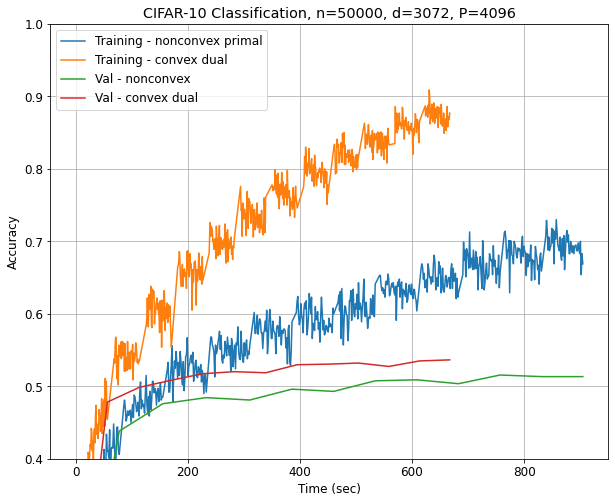

In [14]:
# plot
n = 50000
d= 3072
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 12})
plt.xlabel('Time (sec)');  plt.grid()

plot_no = 1 # select --> 0: cost, 1: accuracy

ylabel_list = ["Cost", "Accuracy"]
plt.ylabel(ylabel_list[plot_no])

plt.title('CIFAR-10 Classification, n={}, d={}, P={}'.format(n, d, num_neurons));

num_all_iters = results_noncvx[4].shape[0] - 1
iters_per_epoch = num_all_iters // (num_epochs)

num_all_iters_cvx = results_cvx_dual[4].shape[0] - 1
iters_per_epoch_cvx = num_all_iters_cvx // num_epochs

epoch_times_noncvx = results_noncvx[4][0:num_all_iters+1:iters_per_epoch]-results_noncvx[4][0]
epoch_times_cvx = results_cvx_dual[4][0:num_all_iters_cvx+1:iters_per_epoch_cvx]-results_cvx_dual[4][0]

# To plot results on the training set
plt.plot(results_noncvx[4][1:]-results_noncvx[4][0], results_noncvx[plot_no], label="Training - nonconvex primal")
plt.plot(results_cvx_dual[4][1:]-results_cvx_dual[4][0], results_cvx_dual[plot_no], label="Training - convex dual")

# To plot results in the validation set
plt.plot(epoch_times_noncvx, results_noncvx[plot_no+2], label="Val - nonconvex")
plt.plot(epoch_times_cvx, results_cvx_dual[plot_no+2], label="Val - convex dual")

plt.legend()
axes = plt.gca()
axes.set_ylim([0.4, 1.0])
plt.savefig("multiclassplot.pdf", bbox_inches="tight")